In [165]:
from glob import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
import re
from enum import Enum
import json
import pandas as pd
import seaborn as sns

# Data Loader

In [166]:
STRIX_SYNTHESIS_PATH = '../experiments/synthesis/strix/'
DEPS_SYNTHESIS_PATH = '../experiments/synthesis/depsynt'
PLAIN_SYNTHESIS_PATH = '../experiments/synthesis/spot-modular'
SPOT_SD_SYNTHESIS_PATH = '../experiments/synthesis/spot-sd-no-decomposed'
SPOT_SD_DECOMPOSED_SYNTHESIS_PATH = '../experiments/synthesis/spot-sd-decomposed'

In [167]:
class Status(Enum):
    ERROR = "Error"
    SUCCESS = "Success"
    NOT_FOUND = "Not Found"
    TIMEOUT = "Timeout"
    
    def __repr__(self):
        return str(self.value)
    
    def __str__(self):
        return str(self.value)

In [168]:
def get_all_benchmarks(path):
    hoa_files = glob(os.path.join(path, "*.out"))
    names = [
        Path(f).stem
        for f in hoa_files
    ]
    return names

print("Total benchmark with Strix" , len(get_all_benchmarks(STRIX_SYNTHESIS_PATH)))
print("Total benchmark with Deps Synthesis" , len(get_all_benchmarks(DEPS_SYNTHESIS_PATH)))
print("Total benchmark with Plain Synthesis" , len(get_all_benchmarks(PLAIN_SYNTHESIS_PATH)))
print("Total benchmark with Spot SD" , len(get_all_benchmarks(SPOT_SD_SYNTHESIS_PATH)))
print("Total benchmark with Spot SD (Decomposed)" , len(get_all_benchmarks(SPOT_SD_DECOMPOSED_SYNTHESIS_PATH)))

Total benchmark with Strix 564
Total benchmark with Deps Synthesis 564
Total benchmark with Plain Synthesis 564
Total benchmark with Spot SD 564
Total benchmark with Spot SD (Decomposed) 564


In [169]:
def extract_vars_from_str(x):
    if len(x) == 0:
        return []
    return x.split(",")

In [170]:
def get_benchmark_name(idx):
    path = "../tools/scripts/benchmarks/{}.txt".format(idx)
    with open(path, 'r') as file:
        name = file.readline().replace("\n", "")
    return name
print(get_benchmark_name(2))

EnemeyModule


In [171]:
def get_external_error(out_content, err_content):
    if 'slurmstepd: error' in err_content and 'oom-kill' in err_content:
        return True, 'Out Of Memory'
    if 'java.lang.OutOfMemoryError' in err_content:
        return True, 'Out Of Memory'
    if 'ltlsynt: Too many acceptance sets used' in err_content:
        return True, 'Spot Limited Accepting State'
    if 'ltlsynt: alternate_players(): Odd cycle detected.' in err_content:
        return True, 'Spot, Odd Cycle Detected'

    return False, None

def read_time_duration(hoa_content):
    match = re.search(r'real\t(\d+)m(\d+\.\d+)s', hoa_content)
    if match:
        minutes = int(match.group(1))
        seconds = float(match.group(2))
        total_time_in_seconds = minutes * 60 + seconds
        total_time_in_milliseconds = total_time_in_seconds * 1000
        return total_time_in_milliseconds
    else:
        return None

def is_timeout(total_duration):
    return total_duration > 899990  # If took 15minutes as timeout

def external_benchmark_loader(path: str, idx: str):
    base = {
        'id': idx,
        'Name': get_benchmark_name(idx),
    }

    out_path = os.path.join(path, idx + ".out")
    err_path = os.path.join(path, idx + ".err")
    if not os.path.exists(out_path) or not os.path.exists(out_path):
        return {
            **base,
            'Status': Status.NOT_FOUND
        }

    with open(out_path, 'r') as f:
        out_content = f.read()

    with open(err_path, 'r') as f:
        err_content = f.read()

    total_duration = read_time_duration(err_content)
    if 'UNREALIZABLE' in out_content:
        realizability = 'UNREALIZABLE'
    elif 'REALIZABLE' in out_content:
        realizability = 'REALIZABLE'
    else:
        realizability = 'UNKNOWN'
    

    is_error, error = get_external_error(out_content, err_content)
    if is_error:
        status = Status.ERROR
        is_completed = False
    elif is_timeout(total_duration):
        status = Status.TIMEOUT
        is_completed = False
    else:
        status = Status.SUCCESS
        is_completed = True

    return {
        'id': idx,
        'Name': get_benchmark_name(idx),
        'Status': status,
        'Is Completed': is_completed,
        'Error': error,
        'Total Duration': total_duration,
        'Realizability': realizability,
    }

In [172]:
def spot_modular_error(out_content, err_content):
    is_external_error, external_error = get_external_error(out_content, err_content)
    if is_external_error:
        return is_external_error, external_error

    matches = re.findall(r"Runtime error:(.*)", err_content)
    if matches:
        return True, matches[0].strip()
    
    return False, None

def spot_modular_benchmark_loader(path: str, idx: str):
    base = {
        'id': idx,
        'Name': get_benchmark_name(idx),
    }
    
    out_path = os.path.join(path, idx + ".out")
    err_path = os.path.join(path, idx + ".err")
    
    if not os.path.exists(out_path) or not os.path.exists(err_path):
        return {
            **base,
            'Status': Status.NOT_FOUND
        }

    with open(out_path, 'r') as f:
        out_content = f.readlines()
    
    with open(err_path, 'r') as f:
        err_content = "\r\n".join(f.readlines())
    
    # total_time = benchmark_json['total_time']
    total_time = read_time_duration(err_content)
    base['Total Duration'] = total_time

    has_error, error = spot_modular_error(out_content, err_content)
    if has_error:
        return {
            **base,
            'Is Completed': False,
            'Status': Status.ERROR,
            'Error': error,
        }

    if(len(out_content) > 0):
        benchmark_json = json.loads(out_content[-1])
    else:
        raise Exception('Missing out content {}'.format(idx))
    
    # Generic Benchmark Name
    is_completed = benchmark_json['is_completed']
    output_vars = benchmark_json['output_vars']
    input_vars = benchmark_json['input_vars']
    is_automaton_built = benchmark_json['automaton']['is_built']
    automaton_build_duration = benchmark_json['automaton'].get('build_duration', None)
    total_states = benchmark_json['automaton'].get('total_states', None)
    total_edges = benchmark_json['automaton'].get('total_edges', None)
    total_output_vars = len(benchmark_json['output_vars'])
    skipped_dependency = benchmark_json['dependency']['skipped_dependencies']

    # Dependency
    find_dependency_duration = benchmark_json['dependency'].get('total_duration', None)
    find_dependency_completed = benchmark_json['dependency']['is_completed']
    total_compatible_pair_states = benchmark_json['dependency'].get('total_pair_state', None)
    find_compatible_pair_states_duration = benchmark_json['dependency'].get('search_pair_state_duration', None)
    dependent_vars = []
    independent_vars = []
    for var_description in benchmark_json["dependency"]['tested_dependencies']:
        if var_description['is_dependent']:
            dependent_vars.append(var_description['name'])
        else:
            independent_vars.append(var_description['name'])
    total_dependent_vars = len(dependent_vars)
    total_independent_vars = len(independent_vars)

    base = {
        **base,
        # Part 1: Benchmark Information
        'Is Completed': is_completed,
        'Total Output Vars': len(output_vars),
        'Total Input Vars': len(input_vars),
        'Output Vars': output_vars,
        'Input Vars': input_vars,
        'Is Automaton Built': is_automaton_built,
        'Automaton Build Duration': automaton_build_duration,

        # Group 2: Automaton
        'Automaton Total States': total_states,
        'Automaton Total Edges': total_edges,

        # Part 3: Dependency
        'Applied Dependency': not skipped_dependency,
        'Total Dependent Variables': total_dependent_vars,
        'Total Independent Variables': total_independent_vars,
        'Dependent Vars': dependent_vars,
        'Independent Vars': independent_vars,
        'Dependency Ratio': total_dependent_vars / total_output_vars,
        'Find Dependency Duration': find_dependency_duration,
        'Find Dependency Completed': find_dependency_completed,
        'Total Compatible Pair States': total_compatible_pair_states,
        'Find Compatible Pair States Duration': find_compatible_pair_states_duration,
    }

    if not is_completed:
        error = None
        status = Status.TIMEOUT

        return {
            **base,
            'Status': status,
            'Error': error,
        }
    
    # Synthesis
    realizability = benchmark_json['synthesis']['independent_strategy']['realizability']
    indeps_synthesis_duration = benchmark_json['synthesis']['independent_strategy']['duration']

    deps_synthesis_duration = benchmark_json['synthesis']['dependent_strategy']['duration']
    deps_synthesis_duration = deps_synthesis_duration if deps_synthesis_duration != -1 else 0

    model_checking_status = benchmark_json['synthesis']['model_checking_status']
    merge_duration = benchmark_json['synthesis'].get('merge_strategies_duration', None)

    synthesis_duration = indeps_synthesis_duration
    if total_dependent_vars > 0:
        synthesis_duration += deps_synthesis_duration

    return {
        **base,
        'Status': Status.SUCCESS,

        # Group 4: Synthesis
        'Realizability': realizability,
        'Independent Synthesis Duration': indeps_synthesis_duration,
        'Dependent Synthesis Duration': deps_synthesis_duration,
        'Synthesis Duration': synthesis_duration,
        'Merge Duration': merge_duration,
        'Model Checking Status': model_checking_status
    }

In [173]:
def visual_status(df, title):
    status_df = df.copy()
    status_df["Status"] = status_df["Status"].astype(str)
    ax = sns.countplot(data=status_df, x='Status')
    ax.bar_label(ax.containers[0])
    ax.set_title(title);

In [174]:
def sort_df_order(df):
    columns_by_order = [
        # Group 1: Benchmark Information
        'id',
        'Name',
        'Status',
        'Is Completed',
        'Error',
        'Total Output Vars',
        'Total Input Vars',
        'Output Vars',
        'Input Vars',

        # Group 2: General Performance
        'Total Duration',
        'Is Automaton Built',
        'Automaton Build Duration',
        'Automaton Total States',
        'Automaton Total Edges',

        # Group 3: Dependency
        'Applied Dependency',
        'Total Dependent Variables',
        'Total Independent Variables',
        'Dependent Vars',
        'Independent Vars',
        'Dependency Ratio',
        'Find Dependency Duration',
        'Find Dependency Completed',
        'Total Compatible Pair States',
        'Find Compatible Pair States Duration',

        # Group 4: Synthesis
        'Realizability',
        'Synthesis Duration',
        'Independent Synthesis Duration',
        'Dependent Synthesis Duration',
        'Merge Duration',
        'Model Checking Status',
    ]
    return df[columns_by_order]

In [175]:
def spot_modular_benchmark_df(directory_path):
    all_df = pd.DataFrame([
        spot_modular_benchmark_loader(directory_path, name)
        for name in get_all_benchmarks(directory_path)
    ])
    all_df.sort_values(by=['Name'], ascending=True, inplace=True)
    all_df = sort_df_order(all_df)
    all_df.set_index("id", inplace=True)
    return all_df

def external_benchmark_df(path):
    df = pd.DataFrame([
    external_benchmark_loader(path, name)
        for name in get_all_benchmarks(path)
    ])
    df.sort_values(by=['Name'], ascending=True, inplace=True)
    df.set_index("id", inplace=True)
    return df

# Strix

In [176]:
strix_df = external_benchmark_df(STRIX_SYNTHESIS_PATH)
strix_df

,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,
492,01,Success,True,None,588.0,REALIZABLE
482,02,Success,True,None,701.0,REALIZABLE
481,03,Success,True,None,2055.0,REALIZABLE
484,05,Success,True,None,5177.0,REALIZABLE
490,06,Success,True,None,6228.0,REALIZABLE
...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,None,72.0,REALIZABLE
426,test_f3987563_2,Success,True,None,285.0,REALIZABLE
290,tmp_13cfc6f2,Success,True,None,2266.0,REALIZABLE


In [177]:
strix_df[strix_df["Status"] == Status.ERROR]

,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,
356,AllLights_06e9cad4,Error,False,Out Of Memory,186270.0,UNKNOWN
323,AllLights_2c5b09da,Error,False,Out Of Memory,183664.0,UNKNOWN
239,AllLights_63831f8c,Error,False,Out Of Memory,184493.0,UNKNOWN
292,AllLights_aeb1d897,Error,False,Out Of Memory,254968.0,UNKNOWN
320,AllLights_b209ff21,Error,False,Out Of Memory,229101.0,UNKNOWN
217,AllLights_d6c5ac79,Error,False,Out Of Memory,260739.0,UNKNOWN
301,AllShades_66f450a4,Error,False,Out Of Memory,156747.0,UNKNOWN
312,Demo1_06e9cad4,Error,False,Out Of Memory,496660.0,UNKNOWN
338,Demo1_2c5b09da,Error,False,Out Of Memory,393951.0,UNKNOWN


In [178]:
strix_df[(strix_df["Status"] == Status.SUCCESS) & (strix_df["Realizability"] == "UNKNOWN")]

,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,


In [179]:
strix_df[(strix_df["Status"] == Status.TIMEOUT)]

,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,
233,FelixSpecFixed5_f82794da,Timeout,False,None,900048.0,UNKNOWN
221,Full_f1477cc5,Timeout,False,None,900061.0,UNKNOWN
134,amba_gr+_3,Timeout,False,None,900044.0,UNKNOWN
125,amba_gr+_4,Timeout,False,None,900030.0,UNKNOWN
129,amba_gr+_5,Timeout,False,None,900018.0,UNKNOWN
142,amba_gr+_6,Timeout,False,None,900027.0,UNKNOWN
145,amba_gr+_7,Timeout,False,None,900032.0,UNKNOWN
141,amba_gr_3,Timeout,False,None,900056.0,UNKNOWN
139,amba_gr_4,Timeout,False,None,900068.0,UNKNOWN


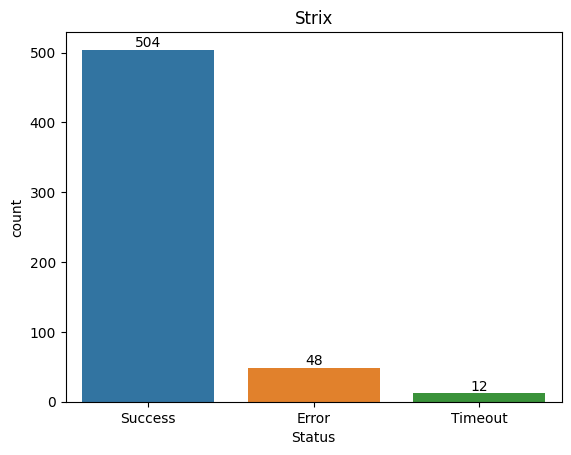

In [180]:
visual_status(strix_df, "Strix")

# Spot SD (No Decomposed)

In [181]:
spot_sd_df = external_benchmark_df(SPOT_SD_SYNTHESIS_PATH)
spot_sd_df

,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,
492,01,Success,True,None,25.0,REALIZABLE
482,02,Error,False,"Spot, Odd Cycle Detected",74.0,UNKNOWN
481,03,Error,False,"Spot, Odd Cycle Detected",2150.0,UNKNOWN
484,05,Timeout,False,None,900008.0,UNKNOWN
490,06,Error,False,Spot Limited Accepting State,140.0,UNKNOWN
...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,None,17.0,REALIZABLE
426,test_f3987563_2,Success,True,None,40.0,REALIZABLE
290,tmp_13cfc6f2,Success,True,None,145.0,REALIZABLE


In [182]:
spot_sd_df[spot_sd_df["Status"] == Status.ERROR]

,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,
482,02,Error,False,"Spot, Odd Cycle Detected",74.0,UNKNOWN
481,03,Error,False,"Spot, Odd Cycle Detected",2150.0,UNKNOWN
490,06,Error,False,Spot Limited Accepting State,140.0,UNKNOWN
489,07,Error,False,Spot Limited Accepting State,123.0,UNKNOWN
487,08,Error,False,Spot Limited Accepting State,151.0,UNKNOWN
...,...,...,...,...,...,...
146,amba_gr_2,Error,False,Out Of Memory,593503.0,UNKNOWN
141,amba_gr_3,Error,False,Out Of Memory,429435.0,UNKNOWN
139,amba_gr_4,Error,False,Out Of Memory,463999.0,UNKNOWN


In [183]:
spot_sd_df[(spot_sd_df["Status"] == Status.SUCCESS) & (spot_sd_df["Realizability"] == "UNKNOWN")]

,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,


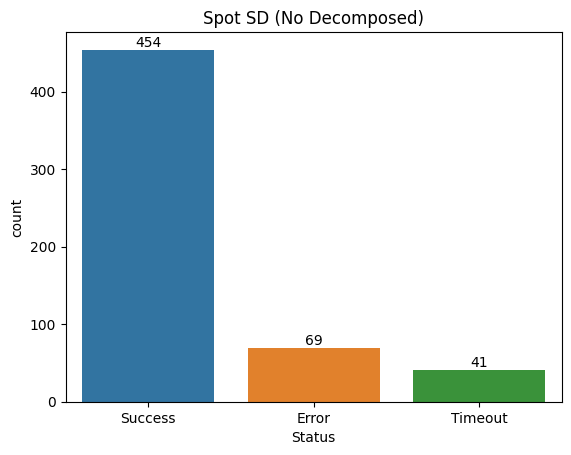

In [184]:
visual_status(spot_sd_df, "Spot SD (No Decomposed)")

# Spot SD (Decomposed)

In [185]:
spot_sd_decomposed_df = external_benchmark_df(SPOT_SD_SYNTHESIS_PATH)
spot_sd_decomposed_df

,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,
492,01,Success,True,None,25.0,REALIZABLE
482,02,Error,False,"Spot, Odd Cycle Detected",74.0,UNKNOWN
481,03,Error,False,"Spot, Odd Cycle Detected",2150.0,UNKNOWN
484,05,Timeout,False,None,900008.0,UNKNOWN
490,06,Error,False,Spot Limited Accepting State,140.0,UNKNOWN
...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,None,17.0,REALIZABLE
426,test_f3987563_2,Success,True,None,40.0,REALIZABLE
290,tmp_13cfc6f2,Success,True,None,145.0,REALIZABLE


In [186]:
spot_sd_decomposed_df[spot_sd_decomposed_df["Status"] == Status.ERROR]

,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,
482,02,Error,False,"Spot, Odd Cycle Detected",74.0,UNKNOWN
481,03,Error,False,"Spot, Odd Cycle Detected",2150.0,UNKNOWN
490,06,Error,False,Spot Limited Accepting State,140.0,UNKNOWN
489,07,Error,False,Spot Limited Accepting State,123.0,UNKNOWN
487,08,Error,False,Spot Limited Accepting State,151.0,UNKNOWN
...,...,...,...,...,...,...
146,amba_gr_2,Error,False,Out Of Memory,593503.0,UNKNOWN
141,amba_gr_3,Error,False,Out Of Memory,429435.0,UNKNOWN
139,amba_gr_4,Error,False,Out Of Memory,463999.0,UNKNOWN


In [187]:
spot_sd_decomposed_df[(spot_sd_decomposed_df["Status"] == Status.SUCCESS) & (spot_sd_decomposed_df["Realizability"] == "UNKNOWN")]

,Name,Status,Is Completed,Error,Total Duration,Realizability
id,,,,,,


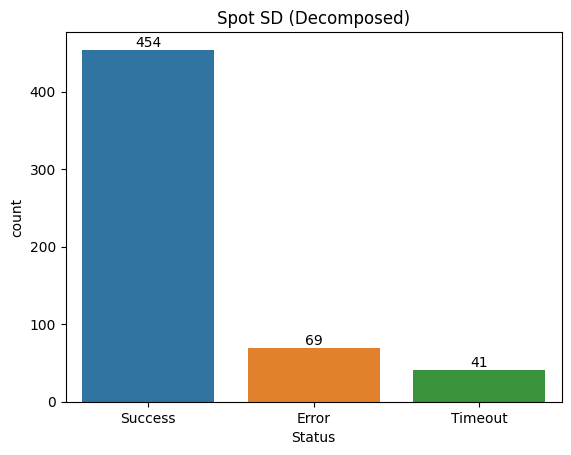

In [188]:
visual_status(spot_sd_decomposed_df, "Spot SD (Decomposed)")

# DepSynt

In [189]:
depsynt_df = spot_modular_benchmark_df(DEPS_SYNTHESIS_PATH)
depsynt_df

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
492,01,Success,True,NaN,3.0,4.0,"[y2, y1, y0]","[x3, x2, x1, x0]",35.0,True,...,0.0,True,55.0,0.0,REALIZABLE,2.0,2.0,0.0,NaN,UNKNOWN
482,02,Success,True,NaN,4.0,4.0,"[y3, y2, y1, y0]","[x3, x2, x1, x0]",93.0,True,...,2.0,True,572.0,2.0,REALIZABLE,53.0,53.0,0.0,NaN,UNKNOWN
481,03,Success,True,NaN,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",2620.0,True,...,60.0,True,5371.0,60.0,REALIZABLE,2437.0,2437.0,0.0,NaN,UNKNOWN
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",900011.0,True,...,6001.0,False,7957.0,6001.0,NaN,NaN,NaN,NaN,NaN,NaN
490,06,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,130.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,NaN,2.0,2.0,"[u0out0f1db1b, u0out0out]","[p0b0c, p0b0a]",101.0,True,...,0.0,True,13.0,0.0,REALIZABLE,2.0,2.0,0.0,76.0,UNKNOWN
426,test_f3987563_2,Success,True,NaN,2.0,2.0,"[u0out250f1dfun0p1db0a1b1b, u0out250out25]","[p0b0c, p0b0a]",105.0,True,...,0.0,True,9.0,0.0,REALIZABLE,2.0,2.0,0.0,76.0,UNKNOWN
290,tmp_13cfc6f2,Success,True,NaN,7.0,6.0,"[u0shutter26ctrl0f1ddo26stop1b, u0shutter26ctr...","[p0p0is26open0shutter26input, p0p0is26closed0s...",660.0,True,...,45.0,True,382.0,3.0,REALIZABLE,161.0,155.0,6.0,406.0,UNKNOWN


In [190]:
depsynt_df[depsynt_df['Status'] == Status.TIMEOUT]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",900011.0,True,...,6001.0,False,7957.0,6001.0,NaN,NaN,NaN,NaN,NaN,NaN
272,Alarm_06e9cad4,Timeout,False,None,6.0,14.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,[p0p02time29between0p1db02time29pm71b02time29p...,900013.0,True,...,37.0,True,531.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
301,AllShades_66f450a4,Timeout,False,None,6.0,19.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,[p0p02time29between0p1db02time29pm71b02time29p...,900007.0,True,...,6002.0,False,34425.0,6002.0,NaN,NaN,NaN,NaN,NaN,NaN
312,Demo1_06e9cad4,Timeout,False,None,24.0,32.0,"[u0music29ctrl0f1dplay0f1dalarm1b1b, u0music29...","[p0p0lt0f1dten2degree1b02room29temperature, p0...",900091.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338,Demo1_2c5b09da,Timeout,False,None,24.0,33.0,"[u0music29ctrl0f1dplay0f1dalarm1b1b, u0music29...","[p0p0lt0f1dten2degree1b02room29temperature, p0...",900086.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,Demo1_63831f8c,Timeout,False,None,24.0,30.0,"[u0music29ctrl0f1dplay0f1dalarm1b1b, u0music29...","[p0p0lt0f1dten2degree1b02room29temperature, p0...",900089.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,Demo1_c2b9e44d,Timeout,False,None,24.0,30.0,"[u0music29ctrl0f1dplay0f1dalarm1b1b, u0music29...","[p0p0lt0f1dten2degree1b02room29temperature, p0...",900084.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,Demo1_d65ed84e,Timeout,False,None,24.0,31.0,"[u0music29ctrl0f1dplay0f1dalarm1b1b, u0music29...","[p0p0lt0f1dten2degree1b02room29temperature, p0...",900074.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358,FelixSpecFixed2_fa4d4ce3,Timeout,False,None,30.0,36.0,"[u0tv29ctrl0f1dturn2on1b, u0tv29ctrl0tv29ctrl,...",[p0p0gt0outside29temperature0room29temperature...,900007.0,True,...,84.0,True,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
depsynt_df[
    (depsynt_df["Realizability"] != "REALIZABLE") &
    (depsynt_df["Realizability"] != "UNREALIZABLE") &
    (depsynt_df["Status"] == Status.SUCCESS)
]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,


In [192]:
depsynt_df[depsynt_df['Status'] == Status.ERROR]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
490,06,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,130.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489,07,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,128.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,08,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,180.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,09,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,156.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,10,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,162.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,lilydemo18,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,69.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,load_balancer,Error,False,alternate_players(): Odd cycle detected.,NaN,NaN,NaN,NaN,55.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
475,load_balancer_unreal1,Error,False,alternate_players(): Odd cycle detected.,NaN,NaN,NaN,NaN,26.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


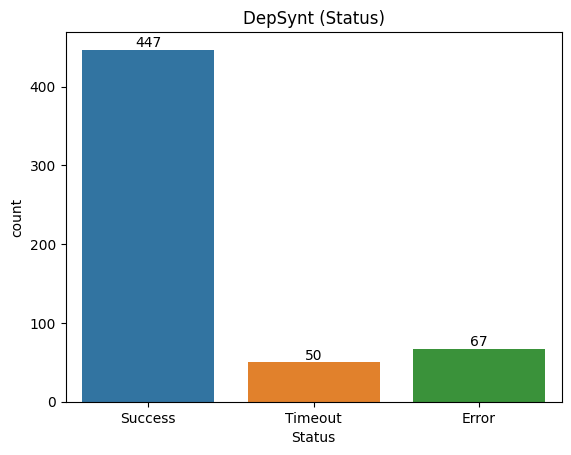

In [193]:
visual_status(depsynt_df, "DepSynt (Status)")

# Spot-Modular

In [194]:
spot_modular_df = spot_modular_benchmark_df(PLAIN_SYNTHESIS_PATH)
spot_modular_df

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
492,01,Success,True,NaN,3.0,4.0,"[y2, y1, y0]","[x3, x2, x1, x0]",26.0,True,...,-1.0,True,-1.0,NaN,REALIZABLE,2.0,2.0,0.0,NaN,UNKNOWN
482,02,Success,True,NaN,4.0,4.0,"[y3, y2, y1, y0]","[x3, x2, x1, x0]",88.0,True,...,-1.0,True,-1.0,NaN,REALIZABLE,54.0,54.0,0.0,NaN,UNKNOWN
481,03,Success,True,NaN,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",2161.0,True,...,-1.0,True,-1.0,NaN,REALIZABLE,2036.0,2036.0,0.0,NaN,UNKNOWN
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",900012.0,True,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490,06,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,134.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,NaN,2.0,2.0,"[u0out0f1db1b, u0out0out]","[p0b0c, p0b0a]",19.0,True,...,-1.0,False,-1.0,NaN,REALIZABLE,2.0,2.0,0.0,NaN,UNKNOWN
426,test_f3987563_2,Success,True,NaN,2.0,2.0,"[u0out250f1dfun0p1db0a1b1b, u0out250out25]","[p0b0c, p0b0a]",21.0,True,...,-1.0,False,-1.0,NaN,REALIZABLE,1.0,1.0,0.0,NaN,UNKNOWN
290,tmp_13cfc6f2,Success,True,NaN,7.0,6.0,"[u0shutter26ctrl0f1ddo26stop1b, u0shutter26ctr...","[p0p0is26open0shutter26input, p0p0is26closed0s...",243.0,True,...,-1.0,True,-1.0,NaN,REALIZABLE,198.0,198.0,0.0,NaN,UNKNOWN


In [195]:
spot_modular_df[spot_modular_df['Status'] == Status.TIMEOUT]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",900012.0,True,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,Alarm_06e9cad4,Timeout,False,None,6.0,14.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,[p0p02time29between0p1db02time29pm71b02time29p...,900016.0,True,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,AllShades_66f450a4,Timeout,False,None,6.0,19.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,[p0p02time29between0p1db02time29pm71b02time29p...,900007.0,True,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,Demo1_06e9cad4,Timeout,False,None,24.0,32.0,"[u0music29ctrl0f1dplay0f1dalarm1b1b, u0music29...","[p0p0lt0f1dten2degree1b02room29temperature, p0...",900096.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338,Demo1_2c5b09da,Timeout,False,None,24.0,33.0,"[u0music29ctrl0f1dplay0f1dalarm1b1b, u0music29...","[p0p0lt0f1dten2degree1b02room29temperature, p0...",900083.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,Demo1_63831f8c,Timeout,False,None,24.0,30.0,"[u0music29ctrl0f1dplay0f1dalarm1b1b, u0music29...","[p0p0lt0f1dten2degree1b02room29temperature, p0...",900101.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,Demo1_c2b9e44d,Timeout,False,None,24.0,30.0,"[u0music29ctrl0f1dplay0f1dalarm1b1b, u0music29...","[p0p0lt0f1dten2degree1b02room29temperature, p0...",900108.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,Demo1_d65ed84e,Timeout,False,None,24.0,31.0,"[u0music29ctrl0f1dplay0f1dalarm1b1b, u0music29...","[p0p0lt0f1dten2degree1b02room29temperature, p0...",900078.0,False,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,FelixSpecFixed4GuaranteesOnly_88f351a6_1,Timeout,False,None,12.0,17.0,"[u0tv29ctrl0f1dturn2on1b, u0tv29ctrl0tv29ctrl,...","[p0p0between0t29am50t29am2423, p0p0asleep0part...",900010.0,True,...,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
spot_modular_df[
    (spot_modular_df["Realizability"] != "REALIZABLE") &
    (spot_modular_df["Realizability"] != "UNREALIZABLE") &
    (spot_modular_df["Status"] == Status.SUCCESS)
]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,


In [197]:
spot_modular_df[spot_modular_df['Status'] == Status.ERROR]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
490,06,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,134.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489,07,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,126.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,08,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,149.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,09,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,145.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,10,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,139.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,lilydemo18,Error,False,Too many acceptance sets used. The limit is 32.,NaN,NaN,NaN,NaN,60.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,load_balancer,Error,False,alternate_players(): Odd cycle detected.,NaN,NaN,NaN,NaN,55.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
475,load_balancer_unreal1,Error,False,alternate_players(): Odd cycle detected.,NaN,NaN,NaN,NaN,33.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


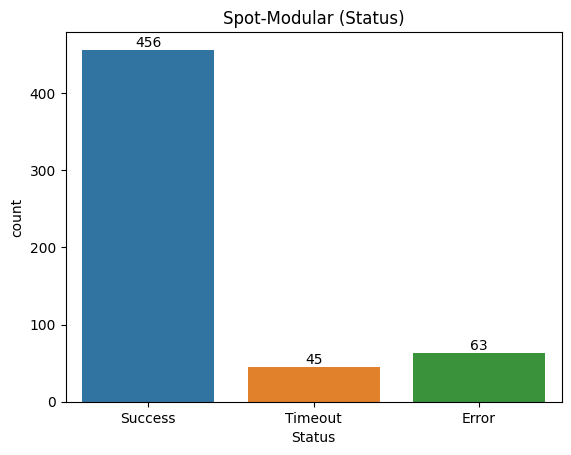

In [198]:
visual_status(spot_modular_df, "Spot-Modular (Status)")

# Sanity Check

## All Tools have same realizability

In [208]:
common_realizability = pd.merge(
    pd.merge(
        spot_sd_df[['Name', 'Realizability']],
        spot_sd_decomposed_df[['Name', 'Realizability']],
        on='Name',
        suffixes=('_sd', '_sd_decomposed'),
    ),
    pd.merge(
        depsynt_df[['Name', 'Realizability']],
        spot_modular_df[['Name', 'Realizability']],
        on='Name',
        suffixes=('_depsynt', '_spot_modular')
    ),
    on='Name'
)
common_realizability = pd.merge(
    common_realizability,
    strix_df[['Name', 'Realizability']].rename(columns={ 'Realizability': 'Realizability_strix' }),
    
    on='Name'
)
# How many different rows
common_realizability['contradiction'] = common_realizability.apply(lambda row: ('REALIZABLE' in row.values) and ('UNREALIZABLE' in row.values), axis=1)
common_realizability[common_realizability['contradiction'] == True]

,Name,Realizability_sd,Realizability_sd_decomposed,Realizability_depsynt,Realizability_spot_modular,Realizability_strix,contradiction


## Find Deps Timeout

In [200]:
depsynt_df["Find Dependency Duration"]

id
492       0.0
482       2.0
481      60.0
484    6001.0
490       NaN
        ...  
425       0.0
426       0.0
290      45.0
435       0.0
436      10.0
Name: Find Dependency Duration, Length: 564, dtype: float64

### DepSynt, Spot-Modular, Spot-SD (Decomposed) have same benchmarks

In [201]:
missing_ids = depsynt_df[~depsynt_df['Name'].isin(spot_modular_df['Name'])]
missing_ids

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,


In [202]:
missing_ids = spot_modular_df[~spot_modular_df['Name'].isin(depsynt_df['Name'])]
missing_ids

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Merge Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
